In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [4]:
class SIRModel:
    """
    SIR (Susceptible-Infected-Recovered) model for epidemic spread
    
    Parameters:
    - beta: transmission rate (contacts per day * probability of transmission)
    - gamma: recovery rate (1/infectious period in days)
    - N: total population
    """
    
    def __init__(self, beta, gamma, N):
        self.beta = beta
        self.gamma = gamma
        self.N = N
        
    def sir_equations(self, y, t):
        """
        System of differential equations for SIR model
        dy/dt = [dS/dt, dI/dt, dR/dt]
        """
        S, I, R = y
        
        dS_dt = -self.beta * S * I / self.N
        dI_dt = self.beta * S * I / self.N - self.gamma * I
        dR_dt = self.gamma * I
        
        return [dS_dt, dI_dt, dR_dt]
    
    def solve(self, initial_conditions, time_points):
        """
        Solve the SIR model
        
        Parameters:
        - initial_conditions: [S0, I0, R0] initial values
        - time_points: array of time points to solve for
        
        Returns:
        - solution: array of [S, I, R] values over time
        """
        solution = odeint(self.sir_equations, initial_conditions, time_points)
        return solution

In [5]:
N = 100000  # Total population
beta = 0.3  # Transmission rate (contacts per day * transmission probability)
gamma = 1/7  # Recovery rate (1/infectious period), flu typically lasts ~7 days

# Initial conditions
I0 = 10  # Initial infected individuals
R0 = 0   # Initially no one recovered
S0 = N - I0 - R0  # Initial susceptible population

# Time points (days)
t = np.linspace(0, 200, 200)

print(f"Model Parameters:")
print(f"Population (N): {N:,}")
print(f"Transmission rate (β): {beta}")
print(f"Recovery rate (γ): {gamma:.3f}")
print(f"Basic reproduction number (R₀): {beta/gamma:.2f}")

Model Parameters:
Population (N): 100,000
Transmission rate (β): 0.3
Recovery rate (γ): 0.143
Basic reproduction number (R₀): 2.10


In [6]:
model = SIRModel(beta, gamma, N)
solution = model.solve([S0, I0, R0], t)

# Extract results
S, I, R = solution[:, 0], solution[:, 1], solution[:, 2]

# Create DataFrame
df = pd.DataFrame({
    'Day': t,
    'Susceptible': S,
    'Infected': I,
    'Recovered': R,
    'Susceptible_Percent': (S/N) * 100,
    'Infected_Percent': (I/N) * 100,
    'Recovered_Percent': (R/N) * 100
})

print("First 10 days of simulation:")
print(df.head(10).round(2))

First 10 days of simulation:
    Day  Susceptible  Infected  Recovered  Susceptible_Percent  \
0  0.00     99990.00     10.00       0.00                99.99   
1  1.01     99986.73     11.71       1.56                99.99   
2  2.01     99982.91     13.71       3.38                99.98   
3  3.02     99978.43     16.06       5.51                99.98   
4  4.02     99973.19     18.80       8.01                99.97   
5  5.03     99967.05     22.02      10.93                99.97   
6  6.03     99959.86     25.78      14.36                99.96   
7  7.04     99951.44     30.19      18.37                99.95   
8  8.04     99941.59     35.35      23.06                99.94   
9  9.05     99930.05     41.39      28.56                99.93   

   Infected_Percent  Recovered_Percent  
0              0.01               0.00  
1              0.01               0.00  
2              0.01               0.00  
3              0.02               0.01  
4              0.02               0.01 

In [7]:
peak_day = df.loc[df['Infected'].idxmax(), 'Day']
peak_infected = df['Infected'].max()
total_infected = df.iloc[-1]['Recovered']
attack_rate = total_infected/S0*100
final_susceptible = df.iloc[-1]['Susceptible']

print("\n=== Outbreak Analysis ===")
print(f"Peak infection day: {peak_day:.0f}")
print(f"Peak infected count: {peak_infected:.0f}")
print(f"Peak infection rate: {peak_infected/N*100:.1f}% of population")
print(f"Total infected (ever): {total_infected:.0f}")
print(f"Attack rate: {attack_rate:.1f}%")
print(f"Final susceptible: {final_susceptible:.0f}")


=== Outbreak Analysis ===
Peak infection day: 58
Peak infected count: 17050
Peak infection rate: 17.1% of population
Total infected (ever): 82209
Attack rate: 82.2%
Final susceptible: 17791


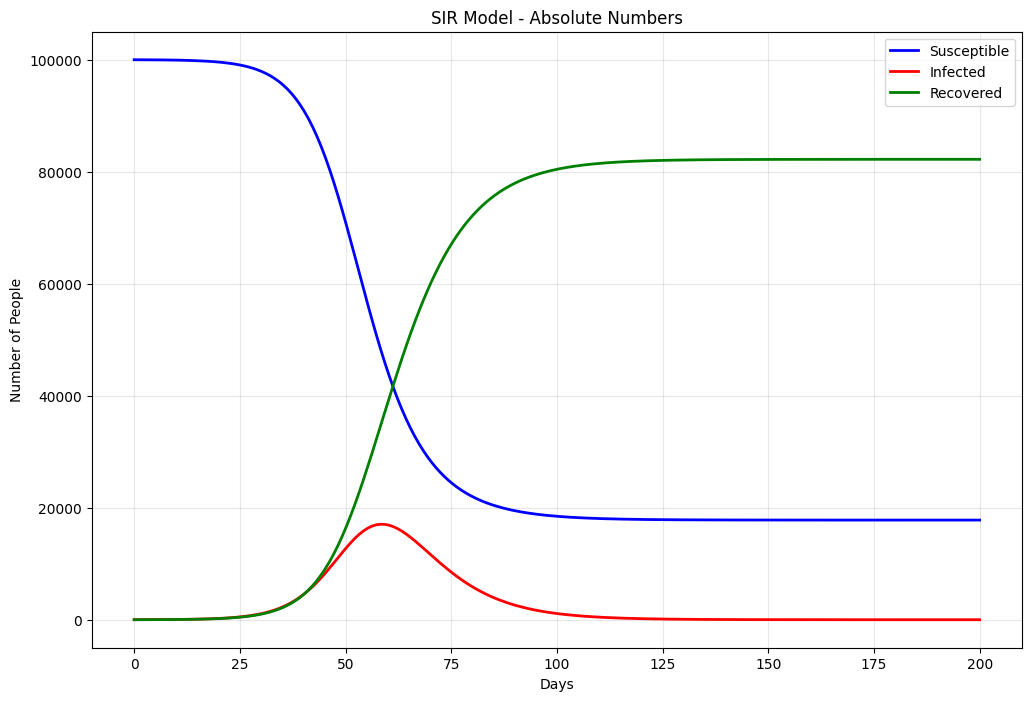

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(df['Day'], df['Susceptible'], 'b-', label='Susceptible', linewidth=2)
plt.plot(df['Day'], df['Infected'], 'r-', label='Infected', linewidth=2)
plt.plot(df['Day'], df['Recovered'], 'g-', label='Recovered', linewidth=2)
plt.xlabel('Days')
plt.ylabel('Number of People')
plt.title('SIR Model - Absolute Numbers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

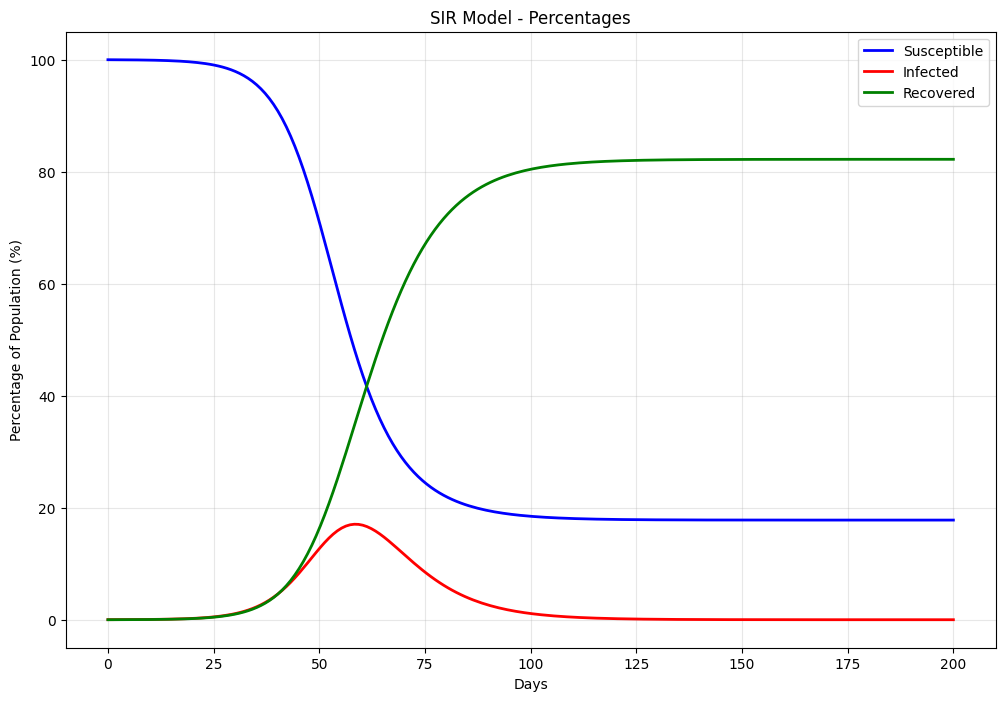

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(df['Day'], df['Susceptible_Percent'], 'b-', label='Susceptible', linewidth=2)
plt.plot(df['Day'], df['Infected_Percent'], 'r-', label='Infected', linewidth=2)
plt.plot(df['Day'], df['Recovered_Percent'], 'g-', label='Recovered', linewidth=2)
plt.xlabel('Days')
plt.ylabel('Percentage of Population (%)')
plt.title('SIR Model - Percentages')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

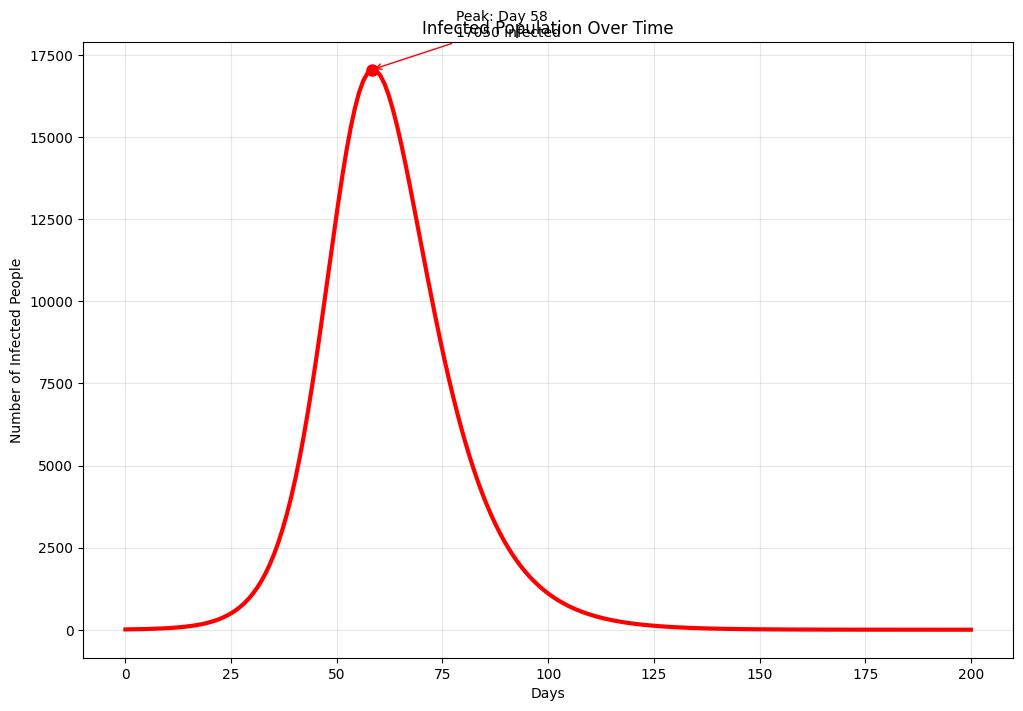

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(df['Day'], df['Infected'], 'r-', linewidth=3)
plt.xlabel('Days')
plt.ylabel('Number of Infected People')
plt.title('Infected Population Over Time')
plt.grid(True, alpha=0.3)

# Mark the peak
plt.plot(peak_day, peak_infected, 'ro', markersize=8)
plt.annotate(f'Peak: Day {peak_day:.0f}\n{peak_infected:.0f} infected', 
            xy=(peak_day, peak_infected), xytext=(peak_day+20, peak_infected+1000),
            arrowprops=dict(arrowstyle='->', color='red'))
plt.show()

In [11]:
def explore_parameters(beta_range, gamma_range, N=100000, I0=10, days=200):
    """
    Function to explore different parameter combinations
    """
    results = []
    
    for beta in beta_range:
        for gamma in gamma_range:
            model = SIRModel(beta, gamma, N)
            t = np.linspace(0, days, days)
            solution = model.solve([N-I0, I0, 0], t)
            
            S, I, R = solution[:, 0], solution[:, 1], solution[:, 2]
            peak_infected = I.max()
            peak_day = t[np.argmax(I)]
            total_infected = R[-1]
            R0 = beta/gamma
            
            results.append({
                'beta': beta,
                'gamma': gamma,
                'R0': R0,
                'peak_day': peak_day,
                'peak_infected': peak_infected,
                'total_infected': total_infected,
                'attack_rate': total_infected/(N-I0)*100
            })
    
    return pd.DataFrame(results)

# Example usage of parameter exploration
print("\n=== Parameter Exploration ===")
beta_values = [0.2, 0.3, 0.4]
gamma_values = [1/5, 1/7, 1/10]  # 5, 7, 10 day infectious periods

param_results = explore_parameters(beta_values, gamma_values)
print(param_results.round(2))



=== Parameter Exploration ===
   beta  gamma   R0  peak_day  peak_infected  total_infected  attack_rate
0   0.2   0.20  1.0      0.00          10.00          388.92         0.39
1   0.2   0.14  1.4    133.67        4544.39        48713.71        48.72
2   0.2   0.10  2.0     90.45       15345.98        79575.53        79.58
3   0.3   0.20  1.5     80.40        6308.75        58285.28        58.29
4   0.3   0.14  2.1     58.29       17050.34        82209.09        82.22
5   0.3   0.10  3.0     50.25       30032.78        94048.35        94.06
6   0.4   0.20  2.0     45.23       15345.98        79684.64        79.69
7   0.4   0.14  2.8     38.19       27514.34        92498.41        92.51
8   0.4   0.10  4.0     35.18       40310.11        98017.46        98.03


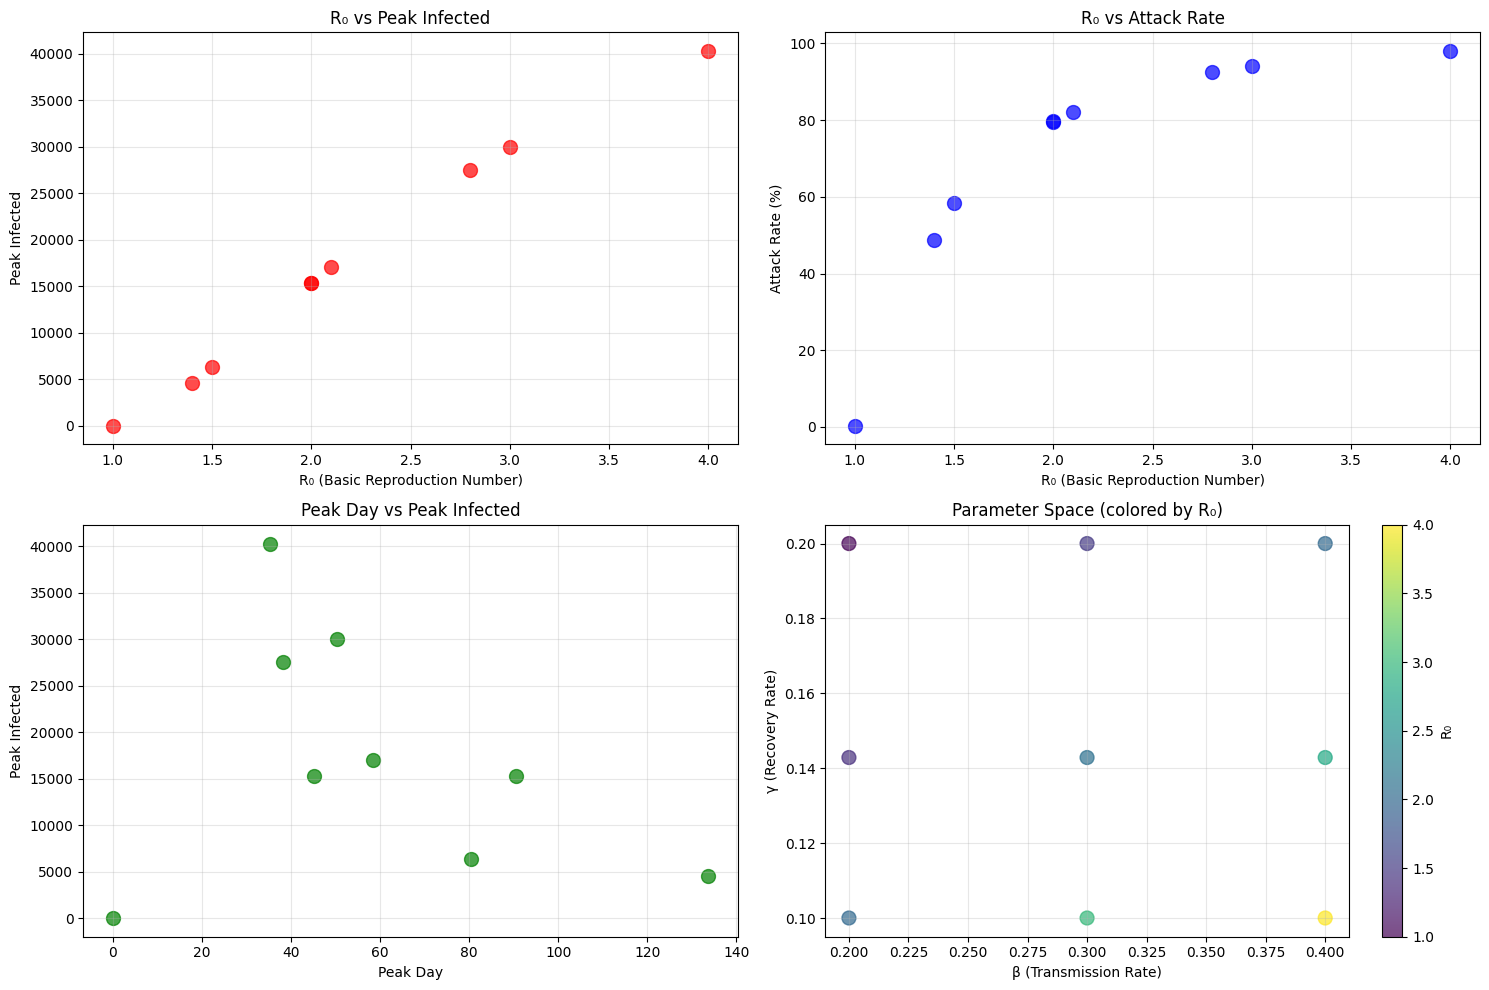

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# R0 vs Peak Infected
ax1.scatter(param_results['R0'], param_results['peak_infected'], c='red', s=100, alpha=0.7)
ax1.set_xlabel('R₀ (Basic Reproduction Number)')
ax1.set_ylabel('Peak Infected')
ax1.set_title('R₀ vs Peak Infected')
ax1.grid(True, alpha=0.3)

# R0 vs Attack Rate
ax2.scatter(param_results['R0'], param_results['attack_rate'], c='blue', s=100, alpha=0.7)
ax2.set_xlabel('R₀ (Basic Reproduction Number)')
ax2.set_ylabel('Attack Rate (%)')
ax2.set_title('R₀ vs Attack Rate')
ax2.grid(True, alpha=0.3)

# Peak Day vs Peak Infected
ax3.scatter(param_results['peak_day'], param_results['peak_infected'], c='green', s=100, alpha=0.7)
ax3.set_xlabel('Peak Day')
ax3.set_ylabel('Peak Infected')
ax3.set_title('Peak Day vs Peak Infected')
ax3.grid(True, alpha=0.3)

# Beta vs Gamma colored by R0
scatter = ax4.scatter(param_results['beta'], param_results['gamma'], 
                     c=param_results['R0'], s=100, alpha=0.7, cmap='viridis')
ax4.set_xlabel('β (Transmission Rate)')
ax4.set_ylabel('γ (Recovery Rate)')
ax4.set_title('Parameter Space (colored by R₀)')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='R₀')

plt.tight_layout()
plt.show()